In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

## Reference image from Zemax

Parabolic mirror RC with polychromatic 600nm to 630nm on-axis source.

Data spacing is 4.0 µm.


In [2]:
import numpy as np
import os

# Source file location
datapath = '../zemax_examples/'
filename = 'toliman-RC-f50_SpiralPupil_psf_0deg_600-630-12waves_4mm.npy'

zemax_ref = np.load(datapath+filename)

In [3]:
print(zemax_ref.shape)

(1024, 1024)


In [4]:
print("Data area {} by {} µm".format(zemax_ref.shape[0]*4,zemax_ref.shape[1]*4))

Data area 4096 by 4096 µm


In [5]:
print("Sized at 11µm pixels gives {} by {} µm".format(zemax_ref.shape[0]*4./11.,zemax_ref.shape[1]*4./11.))

Sized at 11µm pixels gives 372.3636363636364 by 372.3636363636364 µm


In [6]:
import proper
# Resolution is too high, so downsample.
src_pitch = 4e-6 # m/pixel
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

mag = src_pitch / detector_pitch
print("Rescaling from sampling of {} to {}, magnification of {}".format(src_pitch, detector_pitch, mag))
zemax_resized = proper.prop_magnify(zemax_ref, mag, CONSERVE = False, AMP_CONSERVE=False)

Rescaling from sampling of 4e-06 to 1.1e-05, magnification of 0.36363636363636365


/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


(372, 372)


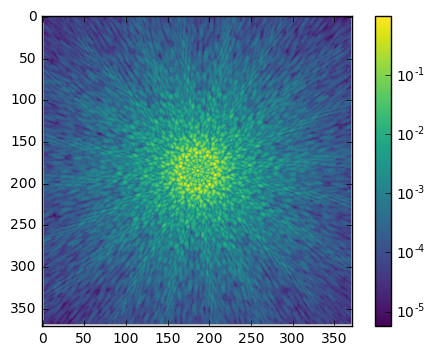

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
sz = zemax_resized.shape
print(sz)
plt.imshow(zemax_resized, cmap='viridis', norm=LogNorm())
plt.colorbar()
plt.show()

In [8]:
npixels = min(npixels, sz[0])
print("All modelling to render to {} pixels".format(npixels))

All modelling to render to 372 pixels


## Add Poisson noise

Scale image to have a peak of 25k to be below saturation, then add photon noise by drawing random values from a Poisson distribution.

In [9]:
intensity_scale = (25000/zemax_resized.max(axis=None))
zemax_noisy = np.random.poisson(
    intensity_scale*np.clip(zemax_resized,0.,1.)
)

In [10]:
# Get lower bound on error
min_err = np.sum((intensity_scale*zemax_resized - zemax_noisy)**2) 
print(min_err)

14497859.9708


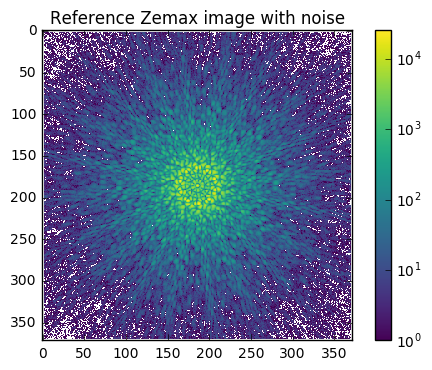

In [11]:
plt.imshow(zemax_noisy, interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference Zemax image with noise')
plt.show()

# Fit with Proper model by tweaking position and flux


In [12]:
from spirals import binarized_ringed_flipped

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)
beam_ratio = 0.4
toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'opd_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }

gridsize = 2048 # sampling of wavefront
wavelengths = [5.999967000000E-01,
                6.014362000000E-01,
                6.036982000000E-01,
                6.064924000000E-01,
                6.096162000000E-01,
                6.129322000000E-01,
                6.163349000000E-01,
                6.197256000000E-01,
                6.229896000000E-01,
                6.259682000000E-01,
                6.284216000000E-01,
                6.300029000000E-01
                ]
wl_weights = [2.984000000000E-02,
                6.193000000000E-02,
                8.348000000000E-02,
                9.704000000000E-02,
                1.052600000000E-01,
                1.096900000000E-01,
                1.109300000000E-01,
                1.088300000000E-01,
                1.024600000000E-01,
                8.984000000000E-02,
                6.769000000000E-02,
                3.294000000000E-02
                ]



# First source, on axis
source = {
            'wavelengths': wavelengths,
            'weights': wl_weights,
            'settings': toliman_settings
            }


In [13]:
print(len(source['wavelengths']))
print(len(source['weights']))

12
12


In [14]:
# Function to generate 
from proper_tools import form_detector_image
errors = []
def model_err(params, view=False):
    tiltx = params[0]
    tilty = params[1]
    flux = params[2]
    settings = toliman_settings.copy()
    settings['tilt_x'] = tiltx 
    settings['tilt_y'] = tilty
    src = source.copy()
    src['settings'] = settings
    im = form_detector_image('prescription_rc_quad', [src], gridsize, detector_pitch, npixels)
    # Adjust scale
    im *= intensity_scale*flux
    if view:
        plt.imshow(im, interpolation = 'none', cmap='viridis',norm=LogNorm())
        plt.colorbar()
        #plt.title('Reference PROPER image with noise')
        plt.show()
    error = np.sum((im - zemax_noisy)**2)
    errors.append((params,error))
    print('Error for offset ({:.2e},{:.2e}) and flux {:.2e}: {}% baseline '.format(tiltx, tiltx, flux, round(100.*error/min_err)))
    return error

## Optimize

In [15]:
from scipy.optimize import minimize
errors=[]
dir_init = [0.1, 0.1,0.8]
opt = minimize(model_err, dir_init, method='L-BFGS-B',
               bounds=[(-2.0,2.0),(-2.0,2.0),(0.5,2.)])

Error for offset (1.00e-01,1.00e-01) and flux 8.00e-01: 416787.0% baseline 
Error for offset (1.00e-01,1.00e-01) and flux 8.00e-01: 416787.0% baseline 
Error for offset (1.00e-01,1.00e-01) and flux 8.00e-01: 416787.0% baseline 
Error for offset (1.00e-01,1.00e-01) and flux 8.00e-01: 416787.0% baseline 
Error for offset (-2.00e+00,-2.00e+00) and flux 2.00e+00: 416375.0% baseline 
Error for offset (-2.00e+00,-2.00e+00) and flux 2.00e+00: 416375.0% baseline 
Error for offset (-2.00e+00,-2.00e+00) and flux 2.00e+00: 416375.0% baseline 
Error for offset (-2.00e+00,-2.00e+00) and flux 2.00e+00: 416375.0% baseline 
Error for offset (-7.13e-01,-7.13e-01) and flux 2.00e+00: 416080.0% baseline 
Error for offset (-7.13e-01,-7.13e-01) and flux 2.00e+00: 416080.0% baseline 
Error for offset (-7.13e-01,-7.13e-01) and flux 2.00e+00: 416080.0% baseline 
Error for offset (-7.13e-01,-7.13e-01) and flux 2.00e+00: 416080.0% baseline 
Error for offset (-6.46e-01,-6.46e-01) and flux 2.00e+00: 416084.0% base

In [16]:
print(opt)

      fun: 60319758336.153656
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.90734863e+04,   1.60217285e+04,  -8.11019897e+07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 8
   status: 0
  success: True
        x: array([-0.56045837, -0.49430007,  2.        ])


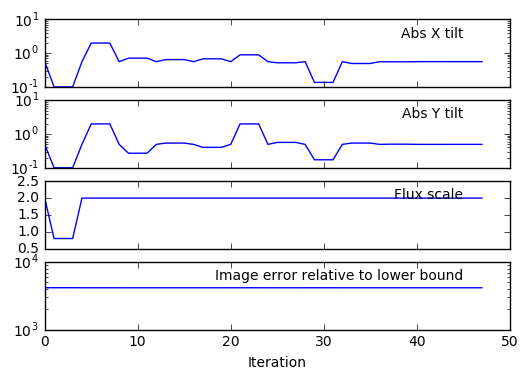

In [17]:
#Visualise the space explored by the optimiser
import matplotlib.pyplot as plt
import math

(I,X,Y,F,E) = zip(*[(i,abs(dx),abs(dy),df,e/min_err) for i,((dx,dy,df),e) in enumerate(errors)])

f, axes = plt.subplots(4, sharex=True)
axes[0].plot(I, X)
axes[0].text(.9,.9,'Abs X tilt',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[0].transAxes)
axes[0].locator_params(axis='y', nbins=6)
axes[0].set_yscale('log')
axes[1].plot(I, Y)
axes[1].text(.9,.9,'Abs Y tilt',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[1].transAxes)
axes[1].locator_params(axis='y', nbins=6)
axes[1].set_yscale('log')
axes[2].plot(I, F)
axes[2].text(.9,.9,'Flux scale',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[2].transAxes)
axes[2].locator_params(axis='y', nbins=6)
axes[3].plot(I, E)
axes[3].text(.9,.9,'Image error relative to lower bound',
        horizontalalignment='right', verticalalignment='top',
        transform=axes[3].transAxes)
axes[3].locator_params(axis='y', nbins=6)
axes[3].set_yscale('log')
axes[3].set_xlabel('Iteration')
plt.show()

In [18]:
# How do things look now?
settings = toliman_settings.copy()
settings['tilt_x'] = opt.x[0] 
settings['tilt_y'] = opt.x[1]
src = source.copy()
src['settings'] = settings
    
detector_image = form_detector_image('prescription_rc_quad', [src], gridsize, detector_pitch, npixels)
detector_image *= intensity_scale*opt.x[2]

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import numpy as np
def view_psf(imarray, pitch_mm, viewport_mm,vmin=None,vmax=None,title=None):
    c = imarray.shape[0]/2. # Assume scaled image
    w = viewport_mm/pitch_mm
    im = plt.imshow(imarray[int(c-w):int(c+w),int(c-w):int(c+w)],cmap='viridis', extent=[x*pitch_mm for x in [-w,w,-w,w]], norm=LogNorm(),vmin=vmin, vmax=vmax)
    if title is not None:
        plt.title(title)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

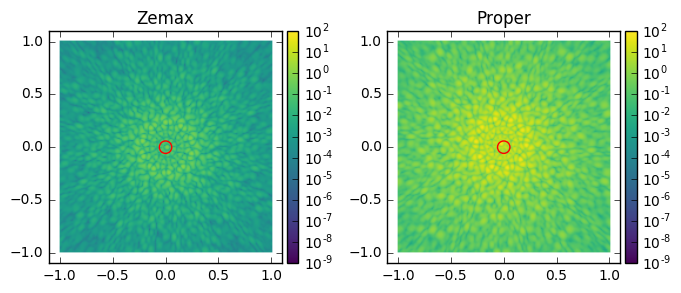

In [20]:
#Side by side plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
fig, axes = plt.subplots(1, 2, figsize=(8,3))
plt.axes(axes[0])
view_psf(zemax_resized, detector_pitch/1e-3, 1., vmin=1e-9, vmax=1e2, title='Zemax')
axes[0].scatter([0], [0], s=80, facecolors='none', edgecolors='r')

plt.axes(axes[1])
view_psf(detector_image, detector_pitch/1e-3, 1., vmin=1e-9, vmax=1e2, title='Proper')
axes[1].scatter([0], [0], s=80, facecolors='none', edgecolors='r')
plt.show()